In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

payment = df_pay[['UserID', 'firstPaymentType', 'gapday', 'avgValue', 'Amount']]
payment.shape

(265308, 5)

In [4]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 13)

In [5]:
engage = pd.merge(left=engage,
                  right=payment,
                  on='UserID',
                  how='left')
engage.shape

(1638631, 17)

In [6]:
engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')


brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [7]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [8]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 20)

In [9]:
pay = engage.loc[engage['gapday'] != 'no_pay']
pay.shape

(578918, 20)

In [10]:
pay['UserID'].unique().size

11225

In [11]:
mask0 = pay['ZeroDay'] == 'zero'
mask2 = pay['nth_day_from_registration'] <= 1

df0 = pay[mask0 & mask2]
df0.shape

(22106, 20)

In [12]:
df0['CutoffDay'] = df0['MinFirstDay'] + 1
df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']

In [13]:
mask3 = pay['ZeroDay'] != 'zero'

others = pay[mask3]
others.shape

(176864, 20)

In [14]:
others['CutoffDay'] = others['MinFirstDay'] + 1

mask5 = others['nth_day_from_registration'] <= others['CutoffDay']


df1 = others[mask5]
df1.shape

(9731, 21)

In [15]:
df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']

In [16]:
print(df0.shape)
print(df1.shape)

(22106, 23)
(9731, 23)


In [17]:
purchaser = pd.concat([df0, df1], ignore_index=True)
purchaser.shape

(31837, 23)

In [18]:
purchaser['UserID'].unique().size

11225

In [19]:
free = engage.loc[engage['gapday'] == 'no_pay']
free.shape

(1059713, 20)

In [20]:
f0 = free['ZeroDay'] == 'zero'

f1 = free['nth_day_from_registration'] <= 1

free0 = free[f0 & f1]
free0.shape

(277010, 20)

In [21]:
free0['CutoffDay'] = free0['MinFirstDay'] + 1
free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
free0['ScaleGapday'] = free0['gapday']

In [22]:
non0 = free.loc[free['ZeroDay'] != 'zero']
non0['CutoffDay'] = non0['MinFirstDay'] + 1

f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']

free1 = non0[f3]
free1.shape

(27493, 21)

In [23]:
free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
free1['ScaleGapday'] = free1['gapday']

In [24]:
non_purchaser = pd.concat([free0, free1], ignore_index=True)
non_purchaser.shape

(304503, 23)

In [25]:
data = pd.concat([purchaser, non_purchaser], ignore_index=True)
data.shape

(336340, 23)

In [26]:
data.isnull().sum()

EventDate                         0
UserID                            0
ActionType                        0
UserJoinedDate                    0
nth_day_from_registration         0
open_time                         0
payment_screen_time               0
DeviceBrand                   31051
UsageTime                         0
Records                           0
lastuse                           0
firstuse                          0
JoinMonth                         0
firstPaymentType             304503
gapday                            0
avgValue                       6987
Amount                         6987
TypeBrand                         0
MinFirstDay                       0
ZeroDay                           0
CutoffDay                         0
ScaleActionDay                    0
ScaleGapday                       0
dtype: int64

In [27]:
data.loc[data['gapday'] != 'no_pay']['UserID'].unique().size

11225

In [28]:
Recency = lambda x: 2 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

# Mode_firstuse_hour = lambda x: x.mode()[0]
# Mode_lastuse_day = lambda x: x.mode()[0]
# Mode_lastuse_hour = lambda x: x.mode()[0]
# Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = data.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords']

active.columns = cols

In [29]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = data.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [30]:
data['Counting'] = [1] * data.shape[0]

brand = data.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [33]:
content_sum = data.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [35]:
Number_of_device = lambda x: len(x.unique())

demo = data.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [36]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(demo.shape)
print(demographics.shape)

(163040, 6)
(163040, 7)
(163040, 4)
(163040, 4)
(163040, 2)
(173193, 5)


In [37]:
data_list = [active, demographics, demo, brand, content_sum, active_median, payment]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 27)

In [40]:
final.isnull().sum()

UserID                         0
Recency                        0
ContentFrequent                0
PaymentScreenFrequent          0
TotalUsageTime                 0
TotalRecords                   0
TotalChild                     0
MedianChildAge                 0
No.Female                      0
No.Male                        0
No.TypeBrand                   0
BigBrand                       0
MediumBrand                    0
SmallBrand                     0
RecordDiscovery                0
RecordEntertainment            0
RecordLearn                    0
UsageTimeDiscovery             0
UsageTimeEntertainment         0
UsageTimeLearn                 0
MedianUsageTime                0
MedianRecord                   0
MedianPaymentScreen            0
firstPaymentType          147758
gapday                    147758
avgValue                       0
Amount                         0
dtype: int64

In [39]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 27)

In [41]:
data = final.copy()

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  158981 non-null  object 
 1   Recency                 158981 non-null  int64  
 2   ContentFrequent         158981 non-null  int64  
 3   PaymentScreenFrequent   158981 non-null  int64  
 4   TotalUsageTime          158981 non-null  float64
 5   TotalRecords            158981 non-null  int64  
 6   TotalChild              158981 non-null  float64
 7   MedianChildAge          158981 non-null  float64
 8   No.Female               158981 non-null  float64
 9   No.Male                 158981 non-null  float64
 10  No.TypeBrand            158981 non-null  int64  
 11  BigBrand                158981 non-null  float64
 12  MediumBrand             158981 non-null  float64
 13  SmallBrand              158981 non-null  float64
 14  RecordDiscovery     

In [44]:
data.describe()

,Recency,ContentFrequent,PaymentScreenFrequent,TotalUsageTime,TotalRecords,TotalChild,MedianChildAge,No.Female,No.Male,No.TypeBrand,...,RecordLearn,UsageTimeDiscovery,UsageTimeEntertainment,UsageTimeLearn,MedianUsageTime,MedianRecord,MedianPaymentScreen,gapday,avgValue,Amount
count,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,...,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,11223.000000,158981.000000,1.589810e+05
mean,1.649549,2.070474,3.402331,21.149211,20.115404,1.064781,5.625380,0.393192,0.671590,1.003522,...,16.335984,3.342206,4.166810,13.640195,8.427733,8.353797,1.269491,11.187116,12404.843944,1.306352e+04
std,0.477113,1.277692,9.765036,28.209698,24.248717,0.300394,2.214603,0.519839,0.542637,0.059246,...,21.260043,8.018888,13.184497,19.450796,9.211392,8.965631,3.034184,31.907007,56048.647024,6.086782e+04
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,0.000000,3.550000,4.000000,1.000000,4.300000,0.000000,0.000000,1.000000,...,3.000000,0.000000,0.000000,2.050000,2.350000,3.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,2.000000,0.000000,11.650000,12.000000,1.000000,5.500000,0.000000,1.000000,1.000000,...,9.000000,0.000000,0.000000,7.430000,5.790000,5.500000,0.000000,1.000000,0.000000,0.000000e+00
75%,2.000000,3.000000,3.000000,27.530000,27.000000,1.000000,6.900000,1.000000,1.000000,1.000000,...,21.000000,2.580000,1.530000,17.760000,11.545000,11.000000,1.000000,7.000000,0.000000,0.000000e+00
max,2.000000,6.000000,417.000000,1185.320000,551.000000,4.000000,13.300000,4.000000,4.000000,2.000000,...,429.000000,335.420000,426.480000,1118.030000,442.680000,193.000000,182.000000,376.000000,999000.000000,2.197000e+06


In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [46]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']

In [47]:
data['AvgTimePerCompletion'].describe()

count    158981.000000
mean          1.029104
std           0.688507
min           0.000000
25%           0.676667
50%           0.870000
75%           1.198824
max          67.370000
Name: AvgTimePerCompletion, dtype: float64

----- AvgTimePerCompletion -----
count    158981.000000
mean          1.029104
std           0.688507
min           0.000000
25%           0.676667
50%           0.870000
75%           1.198824
max          67.370000
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.47404138176434446
* Median: 0.87
* Skewness: 10.86713371428806
* Kurtosis: 680.6209885636168
* Percentage of outliers: 0.06456117397676452
* Number of missing value: 0


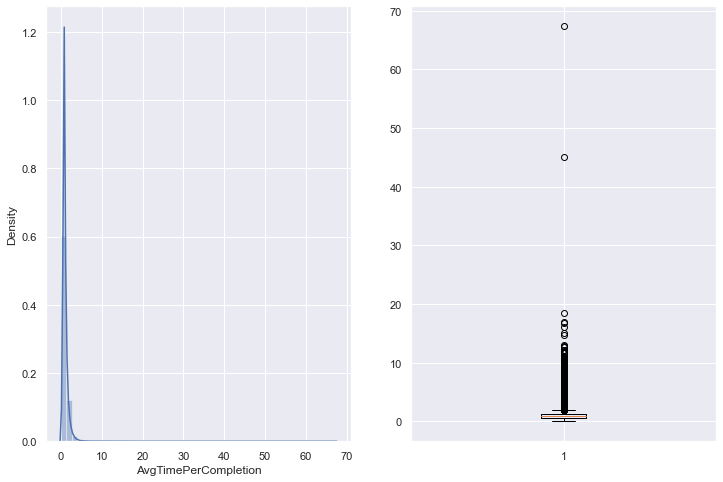

In [48]:
fc.continuous_analysis(data, 'AvgTimePerCompletion')

In [51]:
scaler = MinMaxScaler()

data['ScaledAvgTimePerCompletion'] = scaler.fit_transform(data['AvgTimePerCompletion'].values.reshape(-1, 1))

----- ScaledAvgTimePerCompletion -----
count    158981.000000
mean          0.015275
std           0.010220
min           0.000000
25%           0.010044
50%           0.012914
75%           0.017795
max           1.000000
Name: ScaledAvgTimePerCompletion, dtype: float64
* Variance: 0.00010444391932978781
* Median: 0.012913759833753898
* Skewness: 10.867133714288055
* Kurtosis: 680.6209885636168
* Percentage of outliers: 0.06456117397676452
* Number of missing value: 0


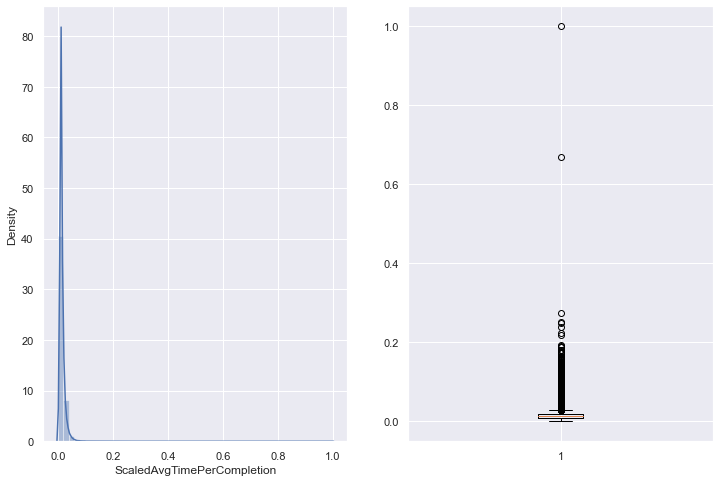

In [54]:
fc.continuous_analysis(data, 'ScaledAvgTimePerCompletion')

In [56]:
data['Interaction'] = data['TotalUsageTime'] * data['TotalRecords']

----- Interaction -----
count    158981.000000
mean       1026.277753
std        3577.957650
min           0.000000
25%          15.600000
50%         140.920000
75%         717.000000
max      338187.270000
Name: Interaction, dtype: float64
* Variance: 12801780.944400841
* Median: 140.92
* Skewness: 23.5188070360374
* Kurtosis: 1370.556152623412
* Percentage of outliers: 0.1326070410929608
* Number of missing value: 0


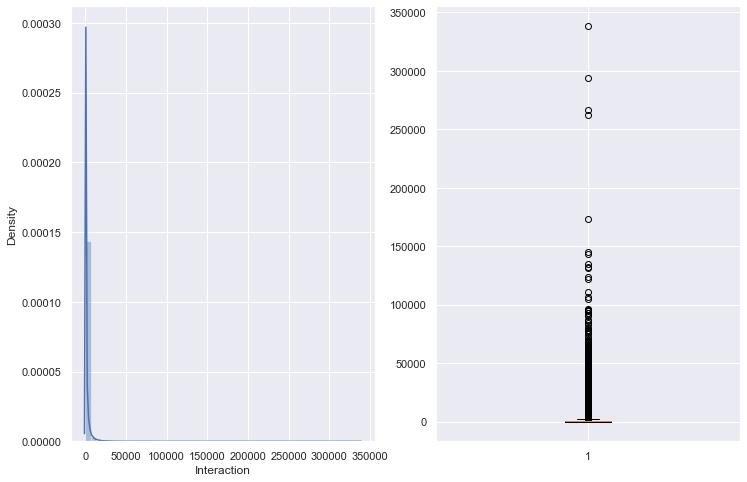

In [57]:
fc.continuous_analysis(data, 'Interaction')

In [58]:
data['ScaledInteraction'] = scaler.fit_transform(data['Interaction'].values.reshape(-1, 1))

----- ScaledInteraction -----
count    158981.000000
mean          0.003035
std           0.010580
min           0.000000
25%           0.000046
50%           0.000417
75%           0.002120
max           1.000000
Name: ScaledInteraction, dtype: float64
* Variance: 0.00011193241648041295
* Median: 0.00041669220724955137
* Skewness: 23.518807036037384
* Kurtosis: 1370.5561526234112
* Percentage of outliers: 0.1326070410929608
* Number of missing value: 0


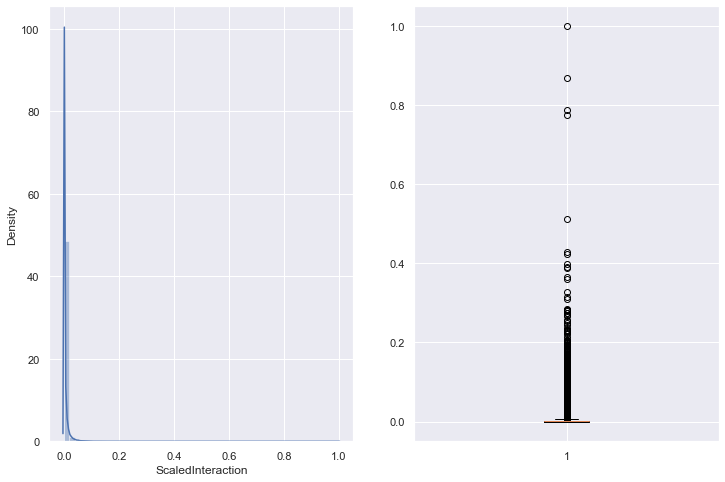

In [59]:
fc.continuous_analysis(data, 'ScaledInteraction')

In [60]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [61]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

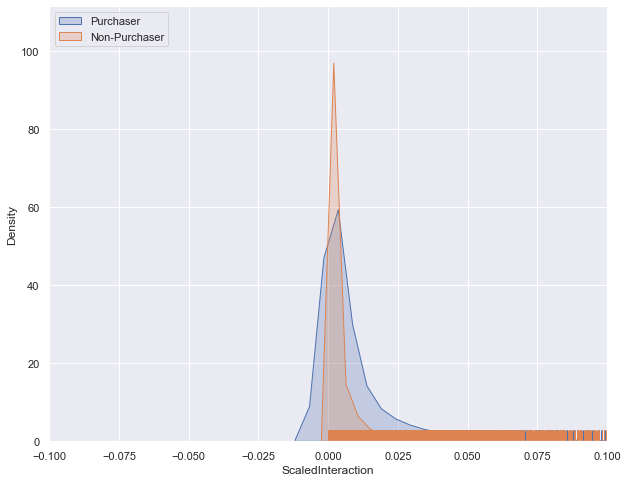

In [74]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ScaledInteraction'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ScaledInteraction'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 0.1]);

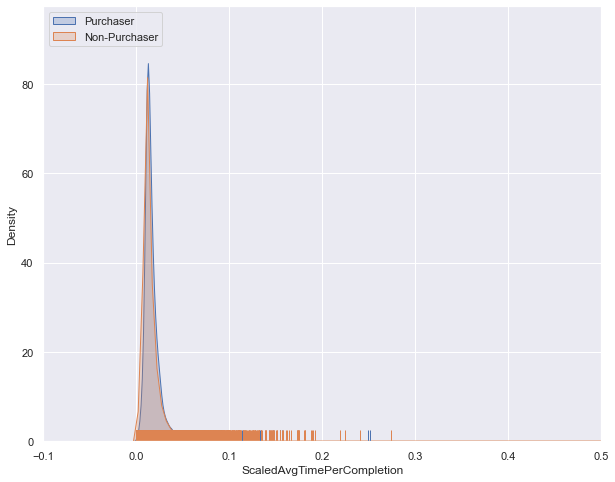

In [67]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ScaledAvgTimePerCompletion'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ScaledAvgTimePerCompletion'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 0.5]);

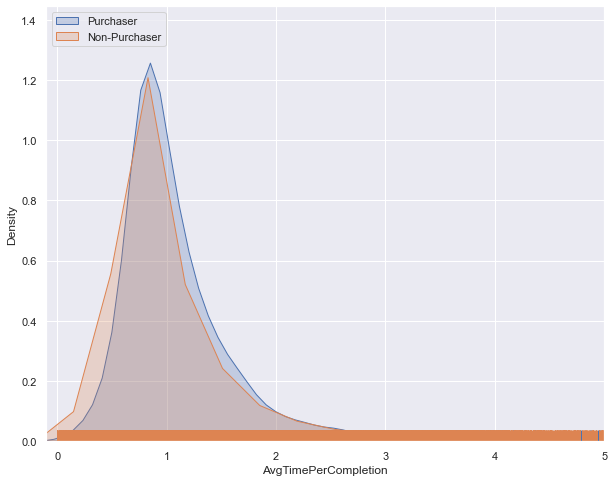

In [72]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['AvgTimePerCompletion'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['AvgTimePerCompletion'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 5]);

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   UserID                      158981 non-null  object 
 1   Recency                     158981 non-null  int64  
 2   ContentFrequent             158981 non-null  int64  
 3   PaymentScreenFrequent       158981 non-null  int64  
 4   TotalUsageTime              158981 non-null  float64
 5   TotalRecords                158981 non-null  int64  
 6   TotalChild                  158981 non-null  float64
 7   MedianChildAge              158981 non-null  float64
 8   No.Female                   158981 non-null  float64
 9   No.Male                     158981 non-null  float64
 10  No.TypeBrand                158981 non-null  int64  
 11  BigBrand                    158981 non-null  float64
 12  MediumBrand                 158981 non-null  float64
 13  SmallBrand    

In [75]:
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']

In [77]:
data['ScaledInteractionLearn'] = scaler.fit_transform(data['InteractionLearn'].values.reshape(-1, 1))
data['ScaledInteractionDiscovery'] = scaler.fit_transform(data['InteractionDiscovery'].values.reshape(-1, 1))
data['ScaledInteractionEntertainment'] = scaler.fit_transform(data['InteractionEntertainment'].values.reshape(-1, 1))

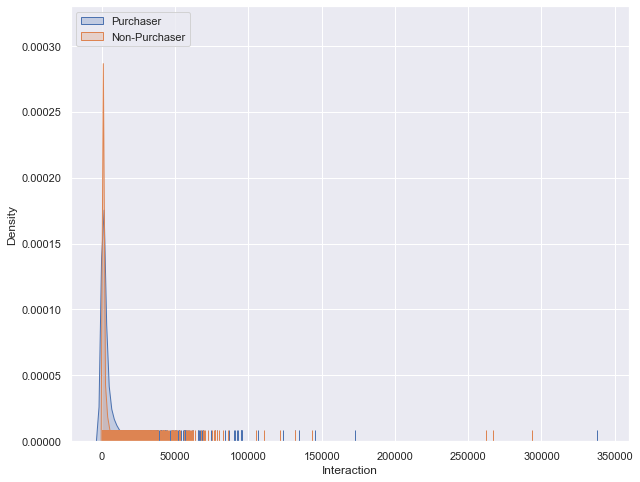

In [168]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['Interaction'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['Interaction'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
# plt.xlim([-0.1, 0.1]);

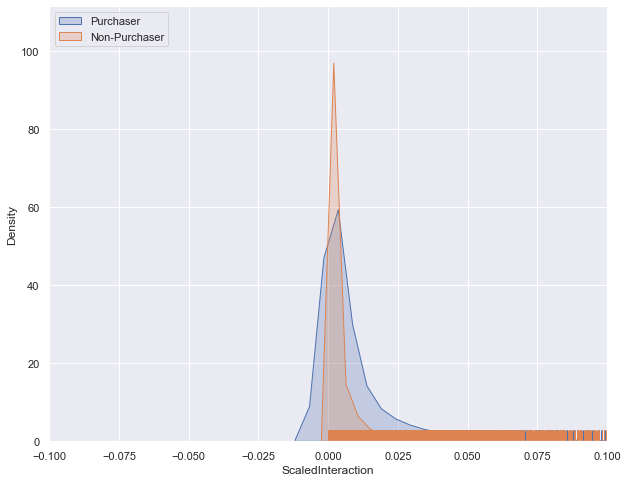

In [166]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ScaledInteraction'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ScaledInteraction'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 0.1]);

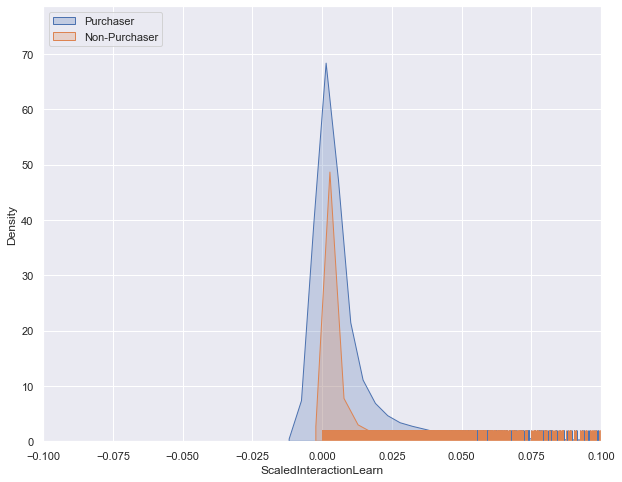

In [78]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ScaledInteractionLearn'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ScaledInteractionLearn'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 0.1]);

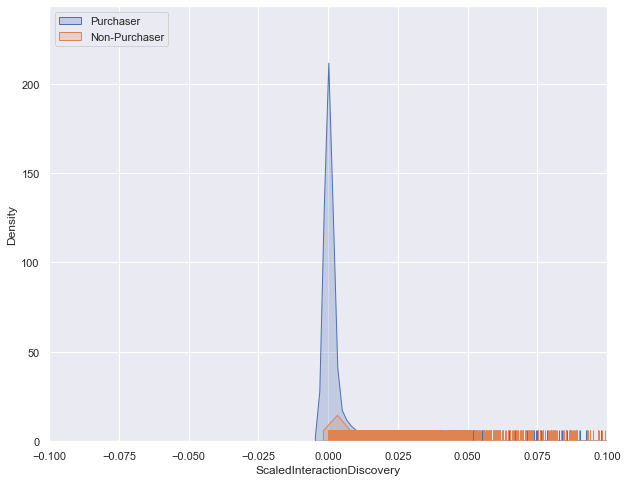

In [82]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ScaledInteractionDiscovery'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ScaledInteractionDiscovery'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 0.1]);

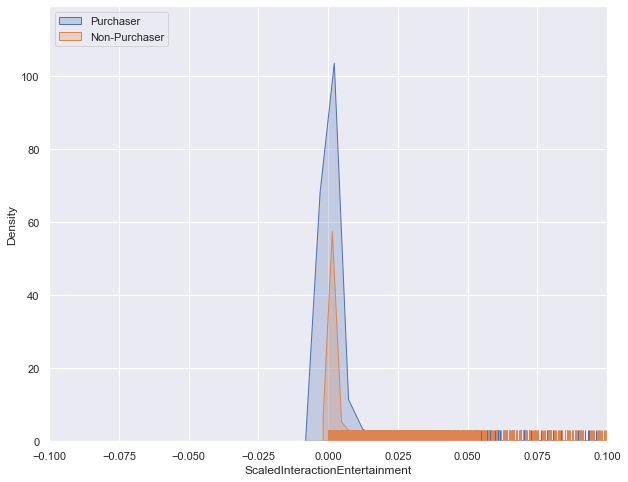

In [83]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ScaledInteractionEntertainment'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ScaledInteractionEntertainment'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-0.1, 0.1]);

In [85]:
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

----- MedianInteraction -----
count    158981.000000
mean        138.640886
std         459.875722
min           0.000000
25%           6.300000
50%          31.400000
75%         119.860000
max       43268.537500
Name: MedianInteraction, dtype: float64
* Variance: 211485.68010471103
* Median: 31.4
* Skewness: 23.632568472555302
* Kurtosis: 1229.5119969870389
* Percentage of outliers: 0.11101326573615715
* Number of missing value: 0


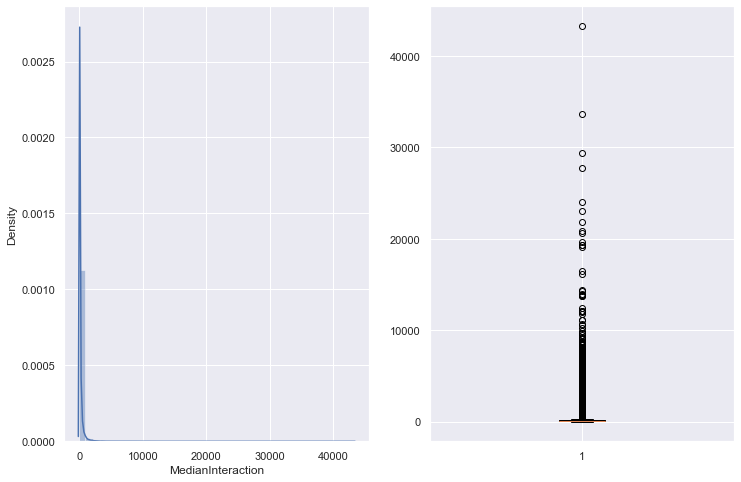

In [86]:
fc.continuous_analysis(data, 'MedianInteraction')

In [87]:
data['MedianInteraction'] = scaler.fit_transform(data['MedianInteraction'].values.reshape(-1, 1))

----- ContentFrequent -----
count    158981.000000
mean          2.070474
std           1.277692
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           6.000000
Name: ContentFrequent, dtype: float64
* Variance: 1.6324972399444617
* Median: 2.0
* Skewness: 1.1571838071213179
* Kurtosis: 0.6323380501638809
* Percentage of outliers: 0.0
* Number of missing value: 0


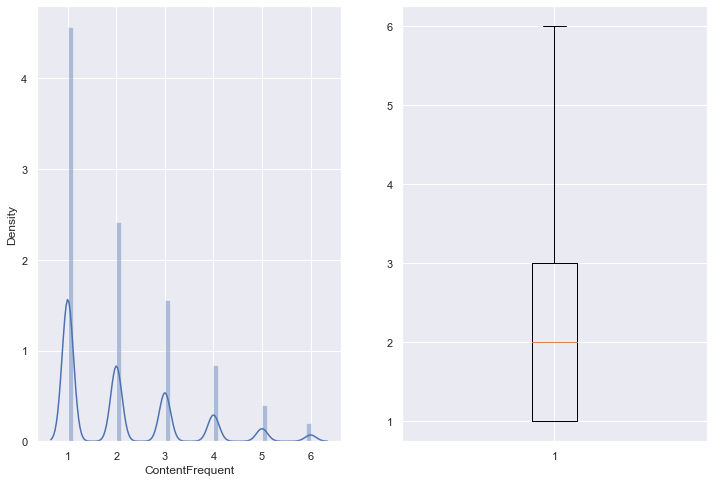

In [89]:
fc.continuous_analysis(data, 'ContentFrequent')

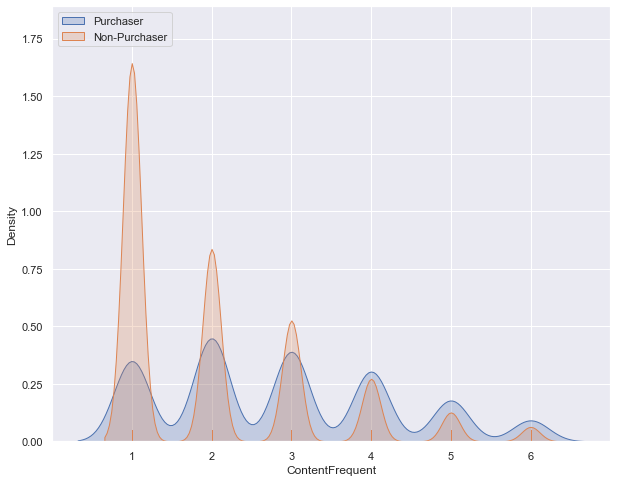

In [91]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ContentFrequent'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ContentFrequent'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

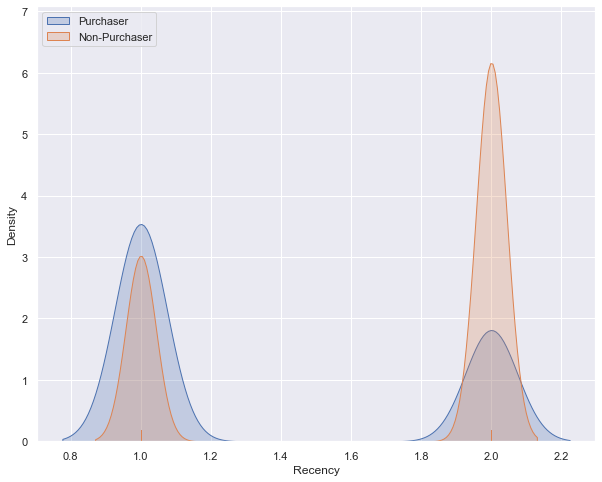

In [92]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['Recency'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['Recency'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

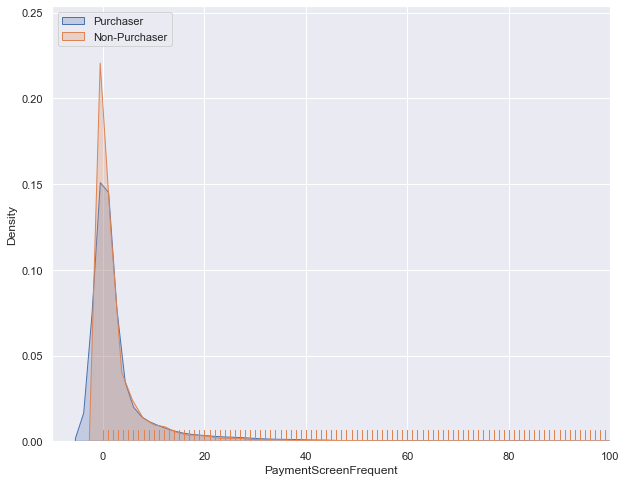

In [164]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['PaymentScreenFrequent'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['PaymentScreenFrequent'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-10, 100]);

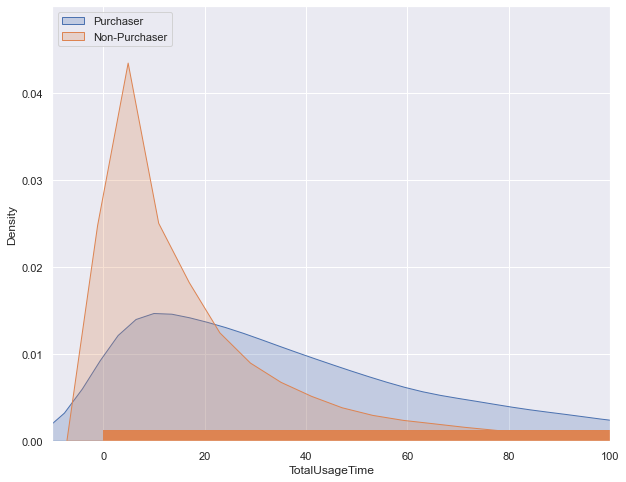

In [165]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['TotalUsageTime'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['TotalUsageTime'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-10, 100]);

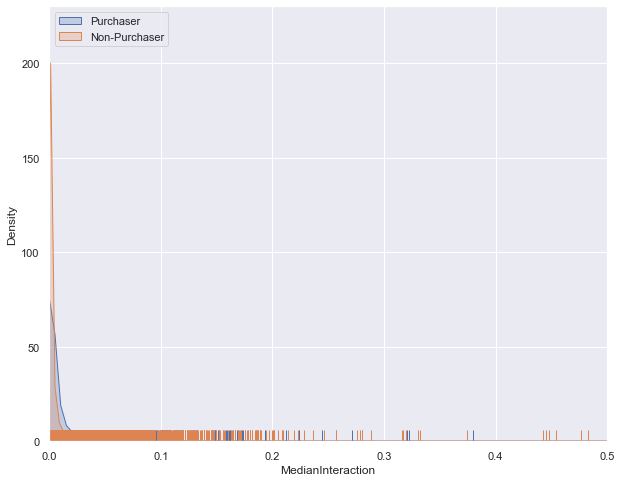

In [172]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['MedianInteraction'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['MedianInteraction'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([0, 0.5]);

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   UserID                          158981 non-null  object 
 1   Recency                         158981 non-null  int64  
 2   ContentFrequent                 158981 non-null  int64  
 3   PaymentScreenFrequent           158981 non-null  int64  
 4   TotalUsageTime                  158981 non-null  float64
 5   TotalRecords                    158981 non-null  int64  
 6   TotalChild                      158981 non-null  float64
 7   MedianChildAge                  158981 non-null  float64
 8   No.Female                       158981 non-null  float64
 9   No.Male                         158981 non-null  float64
 10  No.TypeBrand                    158981 non-null  int64  
 11  BigBrand                        158981 non-null  float64
 12  MediumBrand     

In [94]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'avgValue','Amount', 'gapday'], axis = 1)
y = data['Label']

In [95]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [96]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [97]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [98]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9314772298402315

In [99]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.933

* Confusion Matrix: 
[[29471   266]
 [ 1863   197]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     29737
           1       0.43      0.10      0.16      2060

    accuracy                           0.93     31797
   macro avg       0.68      0.54      0.56     31797
weighted avg       0.91      0.93      0.91     31797



In [100]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.9372877091458045

In [101]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9375

* Confusion Matrix: 
[[29621   116]
 [ 1872   188]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.62      0.09      0.16      2060

    accuracy                           0.94     31797
   macro avg       0.78      0.54      0.56     31797
weighted avg       0.92      0.94      0.92     31797



In [102]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_mm, y_train)

logit_model.score(X_train_mm, y_train)

0.9364935840986287

In [103]:
fc.eval_clf_testset(logit_model, X_test_mm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9368

* Confusion Matrix: 
[[29631   106]
 [ 1903   157]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.60      0.08      0.14      2060

    accuracy                           0.94     31797
   macro avg       0.77      0.54      0.55     31797
weighted avg       0.92      0.94      0.91     31797



In [104]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_rb, y_train)

logit_model.score(X_train_rb, y_train)

0.9358252610391244

In [105]:
fc.eval_clf_testset(logit_model, X_test_rb, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9369

* Confusion Matrix: 
[[29632   105]
 [ 1902   158]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.60      0.08      0.14      2060

    accuracy                           0.94     31797
   macro avg       0.77      0.54      0.55     31797
weighted avg       0.92      0.94      0.91     31797



In [106]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9770568624984275

In [107]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9265

* Confusion Matrix: 
[[28792   945]
 [ 1391   669]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29737
           1       0.41      0.32      0.36      2060

    accuracy                           0.93     31797
   macro avg       0.68      0.65      0.66     31797
weighted avg       0.92      0.93      0.92     31797



ROC AUC score: 0.6465


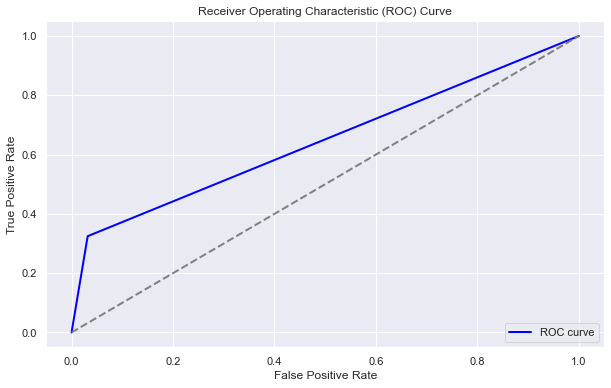

In [108]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [109]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9595546609636433

In [110]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.924

* Confusion Matrix: 
[[28614  1123]
 [ 1295   765]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.41      0.37      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6668


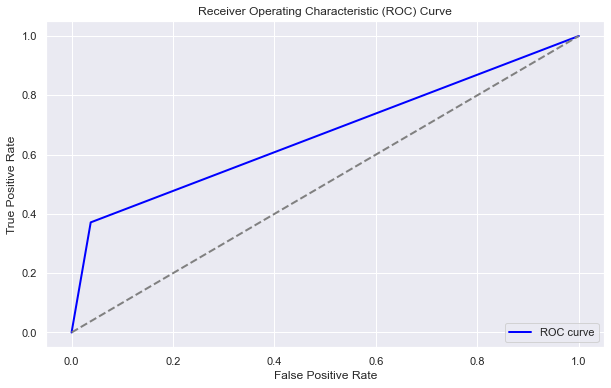

In [111]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [112]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9595389357151843

In [113]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9238

* Confusion Matrix: 
[[28603  1134]
 [ 1290   770]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.40      0.37      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6678


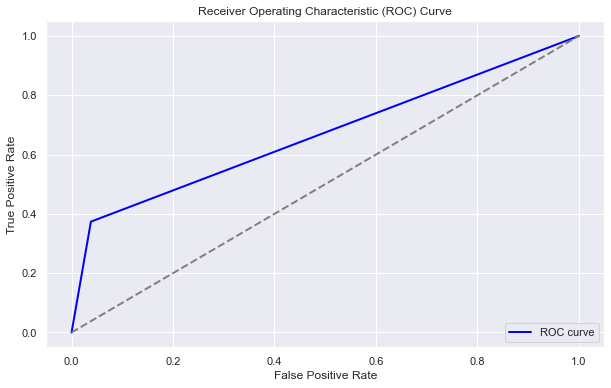

In [114]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [115]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.8,
                               colsample_bytree=0.8)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9057743112341174

In [116]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8617

* Confusion Matrix: 
[[26302  3435]
 [  961  1099]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     29737
           1       0.24      0.53      0.33      2060

    accuracy                           0.86     31797
   macro avg       0.60      0.71      0.63     31797
weighted avg       0.92      0.86      0.88     31797



ROC AUC score: 0.7090


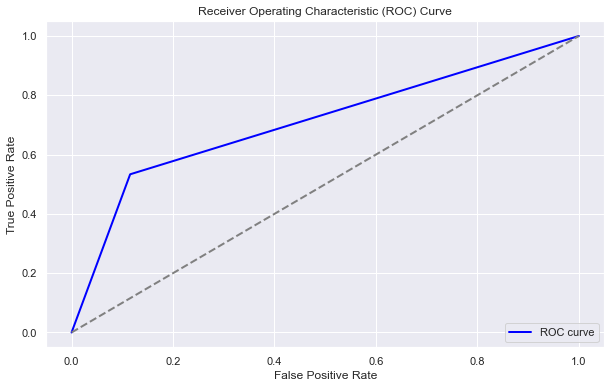

In [117]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [118]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_mm, y_train)

lgbm_model.score(X_train_mm, y_train)

0.9595467983394138

In [119]:
fc.eval_clf_testset(lgbm_model, X_test_mm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9243

* Confusion Matrix: 
[[28616  1121]
 [ 1286   774]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.41      0.38      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.68     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6690


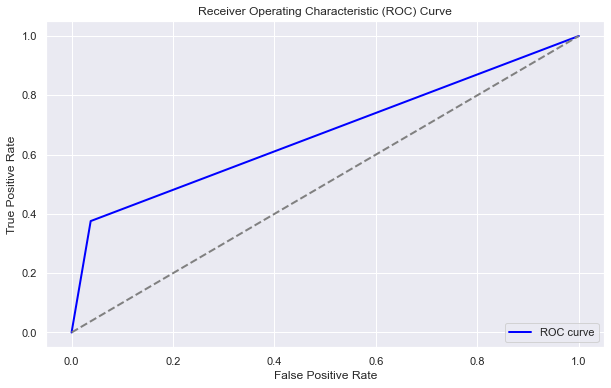

In [120]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_mm))

In [121]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_norm, y_train)

lgbm_model.score(X_train_norm, y_train)

0.9590986287583344

In [122]:
fc.eval_clf_testset(lgbm_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9232

* Confusion Matrix: 
[[28592  1145]
 [ 1296   764]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.40      0.37      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6662


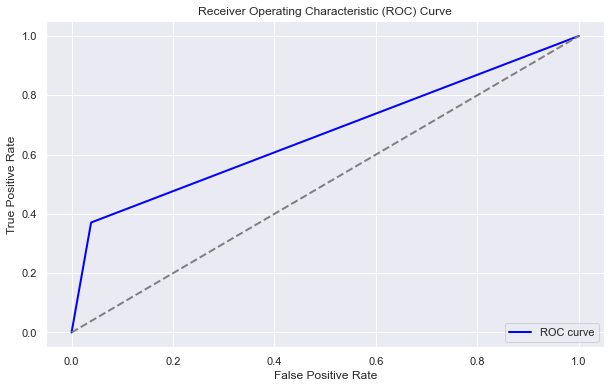

In [123]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_norm))

In [124]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_rb, y_train)

lgbm_model.score(X_train_rb, y_train)

0.9587133601710907

In [125]:
fc.eval_clf_testset(lgbm_model, X_test_rb, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9243

* Confusion Matrix: 
[[28630  1107]
 [ 1301   759]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.41      0.37      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6656


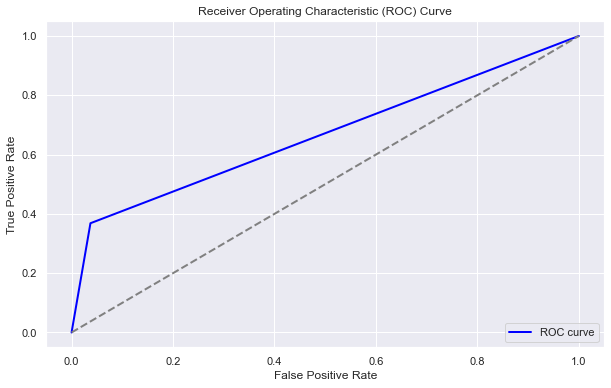

In [126]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_rb))

In [127]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_norm, y_train)

lgbm_model.score(X_train_norm, y_train)

0.9052239275380551

In [128]:
fc.eval_clf_testset(lgbm_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8618

* Confusion Matrix: 
[[26305  3432]
 [  962  1098]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     29737
           1       0.24      0.53      0.33      2060

    accuracy                           0.86     31797
   macro avg       0.60      0.71      0.63     31797
weighted avg       0.92      0.86      0.88     31797



ROC AUC score: 0.7088


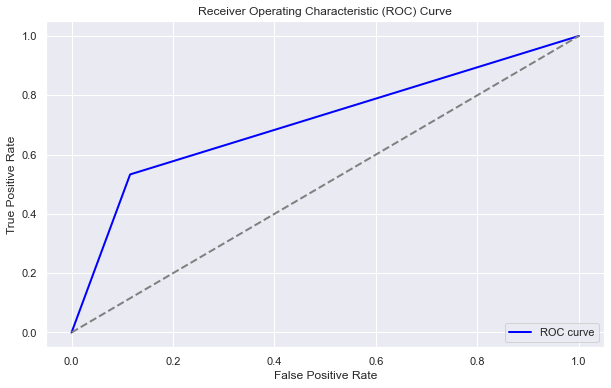

In [129]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_norm))

In [130]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_norm, y_train)

lgbm_model.score(X_train_norm, y_train)

0.903761479431375

In [131]:
fc.eval_clf_testset(lgbm_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8617

* Confusion Matrix: 
[[26288  3449]
 [  949  1111]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     29737
           1       0.24      0.54      0.34      2060

    accuracy                           0.86     31797
   macro avg       0.60      0.71      0.63     31797
weighted avg       0.92      0.86      0.88     31797



ROC AUC score: 0.7117


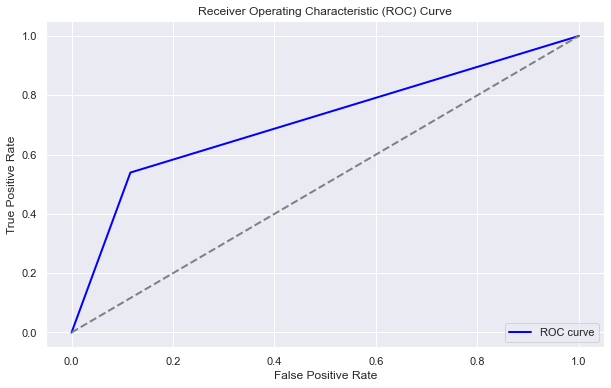

In [132]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_norm))

In [133]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9595467983394138

In [134]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9198

* Confusion Matrix: 
[[28450  1287]
 [ 1264   796]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.38      0.39      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6716


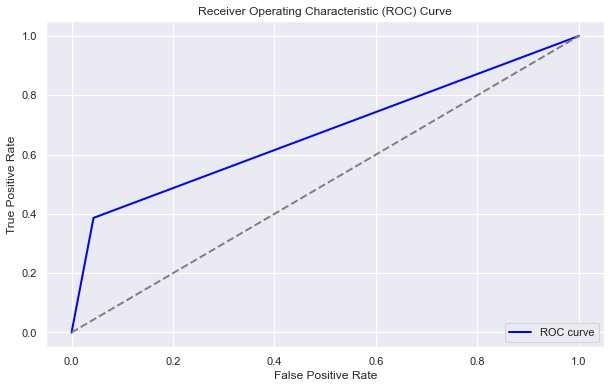

In [135]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [136]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=1,
                               reg_alpha=0.8,
                               scale_pos_weight=6.5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9580371744873569

In [137]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9158

* Confusion Matrix: 
[[28300  1437]
 [ 1240   820]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.36      0.40      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6749


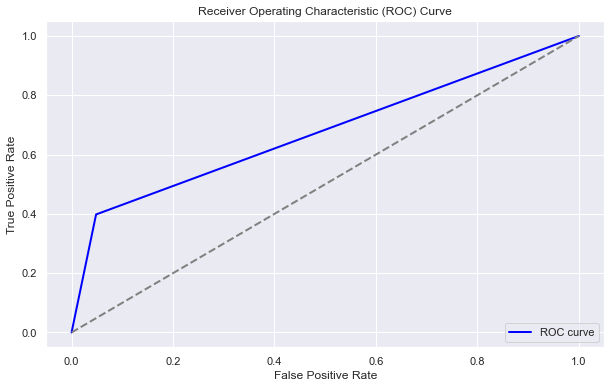

In [138]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [139]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9145254120015096

In [140]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8666

* Confusion Matrix: 
[[26484  3253]
 [  988  1072]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     29737
           1       0.25      0.52      0.34      2060

    accuracy                           0.87     31797
   macro avg       0.61      0.71      0.63     31797
weighted avg       0.92      0.87      0.89     31797



ROC AUC score: 0.7055


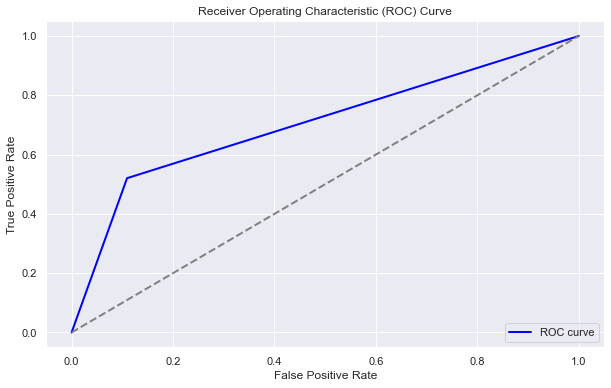

In [141]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [ ]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

In [142]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9510315762989056

In [143]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9416

* Confusion Matrix: 
[[29562   175]
 [ 1681   379]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.68      0.18      0.29      2060

    accuracy                           0.94     31797
   macro avg       0.82      0.59      0.63     31797
weighted avg       0.93      0.94      0.93     31797



ROC AUC score: 0.5890


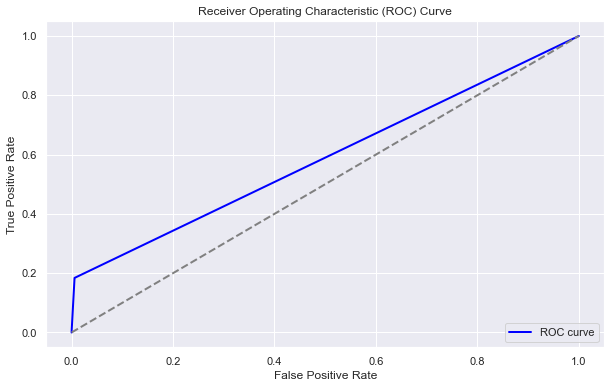

In [144]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [145]:
xgb_clf = xgb.XGBClassifier(random_state=42, 
                            objective= 'binary:logistic',
                            scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                            max_depth=8,
                            min_child_weight=10,
                            subsample=0.8,
                            colsample_bytree=0.85,
                            learning_rate=0.05)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.8295461693294754

In [146]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8155

* Confusion Matrix: 
[[24604  5133]
 [  734  1326]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     29737
           1       0.21      0.64      0.31      2060

    accuracy                           0.82     31797
   macro avg       0.59      0.74      0.60     31797
weighted avg       0.92      0.82      0.86     31797



ROC AUC score: 0.7355


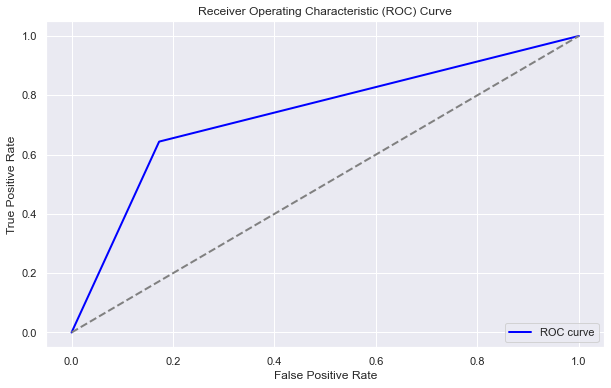

In [147]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [148]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9196203925022015

In [149]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.867

* Confusion Matrix: 
[[26524  3213]
 [ 1017  1043]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     29737
           1       0.25      0.51      0.33      2060

    accuracy                           0.87     31797
   macro avg       0.60      0.70      0.63     31797
weighted avg       0.92      0.87      0.89     31797



ROC AUC score: 0.6991


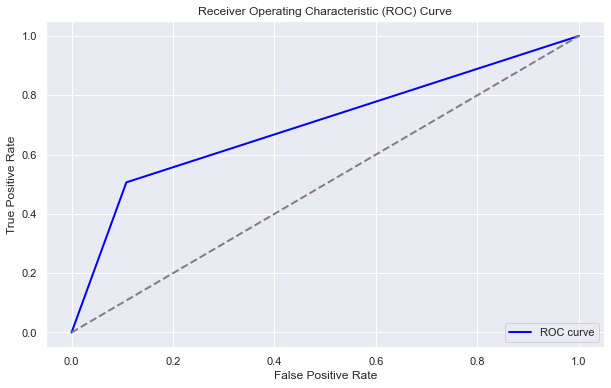

In [150]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [177]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=15,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.8214162158762108

In [178]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8025

* Confusion Matrix: 
[[24189  5548]
 [  731  1329]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.81      0.89     29737
           1       0.19      0.65      0.30      2060

    accuracy                           0.80     31797
   macro avg       0.58      0.73      0.59     31797
weighted avg       0.92      0.80      0.85     31797



ROC AUC score: 0.7293


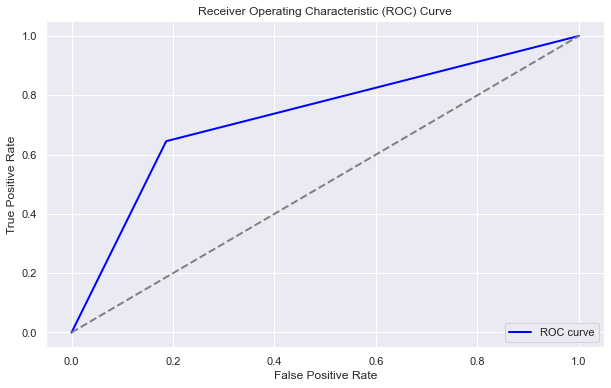

In [179]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [151]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [152]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9805959106806564

In [153]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9645

* Confusion Matrix: 
[[115888   3056]
 [  1465   6775]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    118944
           1       0.69      0.82      0.75      8240

    accuracy                           0.96    127184
   macro avg       0.84      0.90      0.87    127184
weighted avg       0.97      0.96      0.97    127184



In [154]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9133

* Confusion Matrix: 
[[28308  1429]
 [ 1328   732]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.34      0.36      0.35      2060

    accuracy                           0.91     31797
   macro avg       0.65      0.65      0.65     31797
weighted avg       0.92      0.91      0.91     31797



ROC AUC score: 0.6536


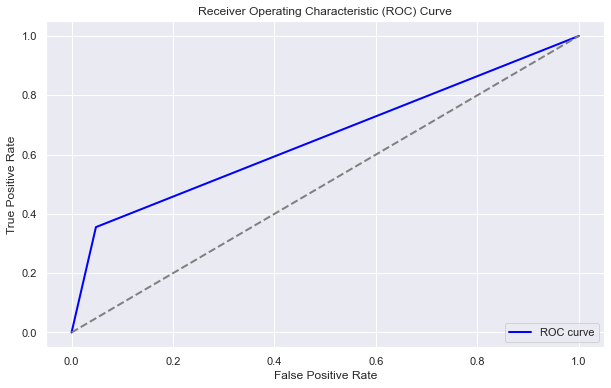

In [155]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [156]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.964937281409739

In [157]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9041

* Confusion Matrix: 
[[27899  1838]
 [ 1211   849]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     29737
           1       0.32      0.41      0.36      2060

    accuracy                           0.90     31797
   macro avg       0.64      0.68      0.65     31797
weighted avg       0.92      0.90      0.91     31797



ROC AUC score: 0.6752


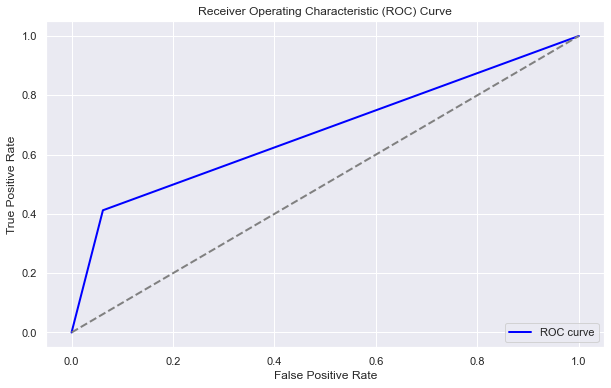

In [158]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [161]:
data.to_csv('DataFeatureTransformed.csv', index=False)